In [108]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [109]:
from fastai.tabular.all import *

In [110]:
 path = "/content/combined_eight_seasons_data_withOdds.csv"
# path = "/content/combined_eight_seasons_data.csv"
# path = "/content/combined_five_seasons_data.csv"

Then we can have a look at how the data is structured:

In [111]:
df = pd.read_csv(path)
df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,ScoreDiff,HomeWinStreak,AwayWinStreak,TGSH,TGSA,Results,Referee,B365H,B365D,B365A,BWH,BWD,BWA
0,Arsenal,Crystal Palace,2,1,1,1,0,0,0,Win,J Moss,1.25,6.5,15.0,1.25,5.50,12.00
1,Leicester,Everton,2,2,0,1,0,0,0,Draw,M Jones,3.20,3.4,2.4,2.90,3.20,2.40
2,Man United,Swansea,1,2,-1,0,1,0,0,Loss,M Dean,1.36,5.0,11.0,1.40,4.75,9.00
3,QPR,Hull,0,1,-1,0,2,0,0,Loss,C Pawson,2.50,3.3,3.1,2.50,3.10,2.85
4,Stoke,Aston Villa,0,1,-1,0,3,0,1,Loss,A Taylor,1.95,3.5,4.5,1.95,3.30,3.90


In [112]:
# without Odds
dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
    cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA', 'Referee'],
    cont_names = ['HomeWinStreak', 'AwayWinStreak'],
    procs = [Categorify, FillMissing, Normalize])

# # with Odds
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA'],
#     cont_names = ['HomeWinStreak', 'AwayWinStreak', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA' ],
#     procs = [Categorify, FillMissing, Normalize])

# # with Only Odds
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam'],
#     cont_names = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA' ],
#     procs = [Categorify, FillMissing, Normalize])

# # with Only Odds from B365
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam'],
#     cont_names = ['B365H', 'B365D', 'B365A'],
#     procs = [Categorify, FillMissing, Normalize])

# # with Only Odds from BWA
# dls = TabularDataLoaders.from_csv(path, path=path, y_names="Results",
#     cat_names = ['HomeTeam', 'AwayTeam'],
#     cont_names = ['BWH', 'BWD', 'BWA'],
#     procs = [Categorify, FillMissing, Normalize])

The last part is the list of pre-processors we apply to our data:

- `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
- `FillMissing` will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
- `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)



In [113]:
splits = EndSplitter(valid_pct=0.1, valid_last=True)(range_of(df))

In [114]:
# without Odds
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA'],
                   cont_names = ['HomeWinStreak', 'AwayWinStreak'],
                   y_names='Results',
                   splits=splits)

# # with Odds
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam', 'TGSH', 'TGSA'],
#                    cont_names = ['HomeWinStreak', 'AwayWinStreak', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA' ],
#                    y_names='Results',
#                    splits=splits)

# # with ONLY Odds
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam'],
#                    cont_names = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA'],
#                    y_names='Results',
#                    splits=splits)

# # with ONLY Odds from B365
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam'],
#                    cont_names = ['B365H', 'B365D', 'B365A'],
#                    y_names='Results',
#                    splits=splits)

# # with ONLY Odds from BW
# to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
#                    cat_names = ['HomeTeam', 'AwayTeam'],
#                    cont_names = ['BWH', 'BWD', 'BWA'],
#                    y_names='Results',
#                    splits=splits)

Once we build our `TabularPandas` object, our data is completely preprocessed as seen below:

In [115]:
to.xs.iloc[:2]

,HomeTeam,AwayTeam,TGSH,TGSA,HomeWinStreak,AwayWinStreak
0,1,9,1,1,-0.247341,-0.629619
1,15,10,1,1,-0.247341,-0.629619


Now we can build our `DataLoaders` again:

In [116]:
dls = to.dataloaders(bs=64)

> Later we will explore why using `TabularPandas` to preprocess will be valuable.

The `show_batch` method works like for every other application:

In [117]:
dls.show_batch()

,HomeTeam,AwayTeam,TGSH,TGSA,HomeWinStreak,AwayWinStreak,Results
0,Man United,Burnley,0,0,2.000000e+00,9.613172e-09,Draw
1,West Ham,Norwich,1,0,4.000000e+00,9.613172e-09,Win
2,Newcastle,Tottenham,0,1,-2.287897e-08,3.000000e+00,Loss
3,Southampton,Brighton,0,0,-2.287897e-08,1.000000e+00,Draw
4,QPR,Stoke,0,0,-2.287897e-08,1.000000e+00,Draw
5,Middlesbrough,Crystal Palace,0,0,-2.287897e-08,2.000000e+00,Loss
6,Stoke,Everton,0,0,1.000000e+00,9.613172e-09,Win
7,Stoke,Liverpool,1,0,4.000000e+00,9.613172e-09,Win
8,Southampton,Norwich,0,0,1.000000e+00,9.613172e-09,Win
9,Huddersfield,Liverpool,0,0,-2.287897e-08,1.000000e+00,Loss


We can define a model using the `tabular_learner` method. When we define our model, `fastai` will try to infer the loss function based on our `y_names` earlier. 

**Note**: Sometimes with tabular data, your `y`'s may be encoded (such as 0 and 1). In such a case you should explicitly pass `y_block = CategoryBlock` in your constructor so `fastai` won't presume you are doing regression.

In [118]:
learn = tabular_learner(dls, metrics=accuracy)

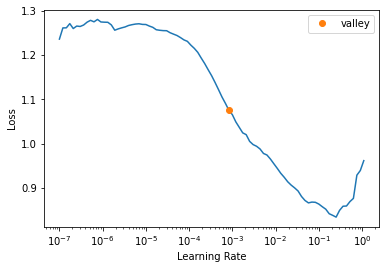

In [119]:
lr = learn.lr_find()

And we can train that model with the `fit_one_cycle` method (the `fine_tune` method won't be useful here since we don't have a pretrained model).

In [120]:
learn.fit_one_cycle(10, lr_max=slice(lr.valley))

epoch,train_loss,valid_loss,accuracy,time
0,0.846235,0.727708,0.769784,00:00
1,0.685543,0.577700,0.769784,00:00
2,0.627804,0.569431,0.769784,00:00
3,0.590235,0.548885,0.762590,00:00
4,0.562169,0.553559,0.751799,00:00
5,0.546316,0.533199,0.766187,00:00
6,0.534788,0.528824,0.762590,00:00
7,0.522484,0.521051,0.766187,00:00
8,0.516042,0.521396,0.766187,00:00
9,0.508000,0.521211,0.762590,00:00


We can then have a look at some predictions:

In [121]:
learn.show_results(max_n=5)

,HomeTeam,AwayTeam,TGSH,TGSA,HomeWinStreak,AwayWinStreak,Results,Results_pred
0,5.0,14.0,1.0,1.0,-0.247341,-0.629619,0.0,2.0
1,9.0,6.0,1.0,1.0,-0.788346,0.312558,1.0,1.0
2,13.0,26.0,1.0,1.0,-0.788346,0.312558,1.0,1.0
3,3.0,8.0,1.0,1.0,-0.788346,1.254736,1.0,1.0
4,16.0,19.0,1.0,1.0,-0.247341,-0.629619,2.0,0.0


Or use the predict method on a row:

In [122]:
row, clas, probs = learn.predict(df.iloc[9])

In [123]:
row.show()

,HomeTeam,AwayTeam,TGSH,TGSA,HomeWinStreak,AwayWinStreak,Results
0,Burnley,Chelsea,0,0,-2.287897e-08,2.0,Loss


In [124]:
clas, probs

(tensor(1), tensor([0.0723, 0.9238, 0.0039]))

In [125]:
# dfTest = pd.read_csv("/content/Test.csv")
# dfTest

In [126]:
# row, clas, probs = learn.predict(dfTest.iloc[8])

In [127]:
# clas, probs

In [128]:
# test_df = dfTest.copy()
# test_df.drop(['Results'], axis=1, inplace=True)
# dl = learn.dls.test_dl(test_df)

In [129]:
# learn.get_preds(dl=dl)